In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt #for the plots
import seaborn as sns 
import re
import OurFunctions as of
import AurasFunctions as af

ASD_phenotypic_original = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD','ASD_phenotypic.csv'))

ASD_phenotypic_original["FIQ"] = ASD_phenotypic_original["FIQ"].apply(af.test_score_fill, args=("FIQ", ASD_phenotypic_original["FIQ"].mean()))


## Data Standarization

We note that as the data for the variables FIQ, VIQ, PIQ was obtained with different tests, there are also different scales for the scores to take into account. In this way, we prefer to apply a standardization so we have all the score on the same scale.


In [ ]:
#For FIQ, the score scale is between 30-170 if the test taken was "DAS", otherwise is 50-160.
#We will unify all the data to the larger scale, i.e. 30-170

# We start defining the condition
condition = (ASD_phenotypic_filtered['FIQ_TEST_TYPE'] != 'DAS') & (ASD_phenotypic_filtered['FIQ'] >= 50) & (ASD_phenotypic_filtered['FIQ'] <= 160)

# Then we standarize the values dictated by the condition, to the new scale
ASD_phenotypic_filtered['FIQ'] = np.where(condition, 
                        (ASD_phenotypic_filtered['FIQ'] - 50) / (160 - 50) * (170 - 30) + 30, 
                        ASD_phenotypic_filtered['FIQ'])


# Entropy

In [3]:
'''
# Calcola la distribuzione delle frequenze dei valori non mancanti nella feature 'SITE_ID'
site_id_counts = ASD_phenotypic[categorical_column_names[0]].value_counts(dropna=True)

# Calcola la proporzione di ciascun valore rispetto al totale dei dati
site_id_proportions = site_id_counts / site_id_counts.sum()

# Calcola l'entropia della distribuzione dei valori non mancanti
site_id_entropy = -(site_id_proportions * np.log2(site_id_proportions)).sum()

# Stampa l'entropia della feature 'SITE_ID'
print('Considering the feature')
print("Entropia di SITE_ID:", site_id_entropy)
'''

'\n# Calcola la distribuzione delle frequenze dei valori non mancanti nella feature \'SITE_ID\'\nsite_id_counts = ASD_phenotypic[categorical_column_names[0]].value_counts(dropna=True)\n\n# Calcola la proporzione di ciascun valore rispetto al totale dei dati\nsite_id_proportions = site_id_counts / site_id_counts.sum()\n\n# Calcola l\'entropia della distribuzione dei valori non mancanti\nsite_id_entropy = -(site_id_proportions * np.log2(site_id_proportions)).sum()\n\n# Stampa l\'entropia della feature \'SITE_ID\'\nprint(\'Considering the feature\')\nprint("Entropia di SITE_ID:", site_id_entropy)\n'

## Entropy Function

In [4]:
def calculate_entropy(column):
    # Sostituisci i valori NaN con "Missing" solo se la colonna è di tipo object
    if column.dtype == 'category':
        # Aggiungi "Missing" alle categorie esistenti
        column = column.cat.add_categories("Missing")
        column_filled = column.fillna("Missing")
    else:
        column_filled = column.fillna("Missing")  # Se è numerica
        
    # Calcola la distribuzione di probabilità delle categorie
    value_counts = column_filled.value_counts()
    probabilities = value_counts / value_counts.sum()
    
    # Calcola l'entropia
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return entropy


## Entropy with "Missing"

In [5]:
# Calcola l'entropia per tutte le colonne
all_entropy = {}
for column in ASD_phenotypic.columns:
    all_entropy[column] = calculate_entropy(ASD_phenotypic[column])

# Ordina il dizionario in base ai valori di entropia in ordine decrescente
sorted_entropy = {k: v for k, v in sorted(all_entropy.items(), key=lambda item: item[1], reverse=True)}

# Plot dell'entropia per tutte le colonne
# Definisci i colori per le feature categoriche e numeriche
color_categorical = 'skyblue'
color_numerical = 'lightgreen'
plt.figure(figsize=(12, 6))
plt.bar(sorted_entropy.keys(), sorted_entropy.values(), color=[color_categorical if col in category_columns.columns else color_numerical for col in sorted_entropy.keys()])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Entropy')
plt.title('Entropy of All Features (NaN treated as "Missing" for object types)')
plt.show()

NameError: name 'ASD_phenotypic' is not defined

## Entropy with NaN 

In [ ]:
# Calcolo dell'entropia per tutte le colonne
all_entropy_dropna = {}

for column in ASD_phenotypic.columns:
    # Rimuovi i valori NaN dalla colonna
    column_without_nan = ASD_phenotypic[column].dropna()
    
    # Se la colonna è vuota dopo aver rimosso i NaN, imposta l'entropia a 0
    if column_without_nan.empty:
        entropy = 0
    else:
        # Calcola la distribuzione di probabilità delle categorie
        value_counts = column_without_nan.value_counts()
        probabilities = value_counts / value_counts.sum()
        
        # Calcola l'entropia
        entropy = -np.sum(probabilities * np.log2(probabilities))
    # Memorizza l'entropia calcolata per la colonna
    all_entropy_dropna[column] = entropy

# Plot dell'entropia per tutte le colonne
# Ordina il dizionario in base ai valori di entropia in ordine decrescente
sorted_entropy_dropna = {k: v for k, v in sorted(all_entropy_dropna.items(), key=lambda item: item[1], reverse=True)}
plt.figure(figsize=(12, 6))
plt.bar(sorted_entropy_dropna.keys(), sorted_entropy_dropna.values(), color=[color_categorical if col in category_columns.columns else color_numerical for col in sorted_entropy_dropna.keys()])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Entropy')
plt.title('Entropy of All Features (NaNs Ignored)')
plt.show()


## Comparison between two entropies

In [ ]:
# Sovrapposizione dei due plot

# Calcola le differenze tra le entropie con e senza NaN per ogni feature
differences = {}
for column in all_entropy.keys():
    difference = all_entropy_dropna[column] - all_entropy[column]
    differences[column] = difference

# Crea il grafico a dispersione delle differenze
plt.figure(figsize=(12, 6))
plt.scatter(range(len(differences)), list(differences.values()), color='skyblue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  # Aggiungi una linea orizzontale a y=0 per la visualizzazione
plt.xlabel('Feature')
plt.ylabel('Difference in Entropy (Drop NaN - Keep NaN)')
plt.title('Scatter Plot of Entropy Differences (Drop NaN vs Keep NaN)')
plt.xticks(range(len(differences)), list(differences.keys()), rotation=90)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# CATEGORICAL FEATURES ANALYSIS

### COMORBIDITY

COMORBIDITY indicates if the subject present some othe pathology or disease or particular detail that is important to specify.

In [ ]:
column_name = 'COMORBIDITY'

# Get unique values and their frequencies
unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'COMORBIDITY' and their frequencies:
nan: 1048
ADHD INATTENTIVE: 7
NONE : 5
ADHD COMBINED: 4
MOOD DISORDER NOS: 4
ADHD INATTENTIVE : 3
ODD: 2
ADHD NOS: 2
GENERALIZED ANXIETY DISORDER: 2
GENERALIZED ANXIETY DISORDER; SPECIFIC PHOBIA; ENURESIS; ENCOPRESIS: 1
ANXIETY DISORDER NOS: 1
MOOD DISORDER NOS; SEPARATION ANXIETY DX; ENURESIS: 1
SOCIAL PHOBIA; SPECIFIC PHOBIA: SPIDERS : 1
ANXIETY DISORDER NOS & DEPRESSIVE DISORDER NOS IN FULL REMISISON (ON TRETAMENT): 1
ENURESIS; TIC DISORDER NOS: 1
DISRUPTIVE DISORDER NOS: 1
SPECIFIC PHOBIA: BUTTERFLIES: 1
DYSTHYMIA: 1
DYSTHYMIA : 1
DYSTHYMIA  : 1
SPECIFIC PHOBIA: NEEDLES/SHOTS : 1
DYSTHYMIA; AGORAPHOBIA DX; : 1
SOCIAL PHOBIA; : 1
MOOD NOS: 1
SPECIFIC PHOBIA: GOING DOWN THE STAIRS: 1
GENERALIZED ANXIETY DISORDER; SPECIFIC PHOBIA: BUGS; DOGS; ELEVATORS: 1
DIURNAL & NOCTURNAL ENURESIS; ENCOPRESIS; TRANSIENT TIC DISORDER: 1
ADHD: 1
ADHD (INATTENTIVE; PRESENT); ODD; MDE (PAST); PHOBIA (SIMPLE AND SOCIAL): 1
ADHD COMBINED TYPE; 

We can see that there is a lot of variability between the commorbities and the combinations of them in the patients. We note as well that there is a large quantity of NaN values. To understand better how the data was collected and how to work with it, we want to understand if the large amount of NaN is due to differences in the protocols between different centers of data collection.

In [ ]:
non_nan_counts = ASD_phenotypic.groupby('SITE_ID')['COMORBIDITY'].count()
print(non_nan_counts)


SITE_ID
CALTECH      0
CMU          0
KKI         16
LEUVEN       0
MAX_MUN      0
NYU         41
OHSU         0
OLIN         0
PITT         0
SBL          7
SDSU         0
STANFORD     0
TRINITY      0
UCLA         0
UM           0
USM          0
YALE         0
Name: COMORBIDITY, dtype: int64


As we anticipated, it seems that only NYU, KKI and SBL collected data about the commorbities. We can also note that they didn't collected it for all their subjects (total subjects for NIU = 184, KKI = 55, SBL = 30). In this way is difficult to understand how to treat the other subjects, because there isn' a clear tendency to follow. We can ipotetize that the other centers didn't collect data about commorbities, but we can't say with security that the missing values for the NYU, KKI and SBL center mean that the other subjects haven't commorbities. 

Taking into account the existent limitance in the available data, we decided that the less risky option is to treat the NaN values as None, while for the other commorbities we will reduce them to macrogroups. As our other dataset is about ADH, the selected macrogroups are: 
- patients that presents a form of ADHD, catalogated as ADHD
- patients that has other disorders, catalogated as OTHER_MENTAL_DISORDER

In [ ]:

# To make this we create a function that is able to treat each case as we defined
import re

def replace_value(x):
    if pd.isna(x) or x == "None":
        return "None"
    elif re.search(r'\bADHD\b', x, flags=re.IGNORECASE):
        return "ADHD"
    else:
        return "OTHER_MENTAL_DISORDER"

# Assuming your DataFrame is named 'data' and the column with strings is named 'feature'
# Apply the function to the 'feature' column
ASD_phenotypic['COMORBIDITY'] = ASD_phenotypic['COMORBIDITY'].apply(replace_value)

Then we check the new distribution

In [ ]:
column_name = 'COMORBIDITY'

# Get unique values and their frequencies
unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'COMORBIDITY' and their frequencies:
None: 1048
OTHER_MENTAL_DISORDER: 38
ADHD: 26


### MEDICATION_NAME

This feature indicate which are the principals active ingredients of the medication that the patient is taking

In [ ]:
column_name = 'MEDICATION_NAME'

# Get unique values and their frequencies
unique_values_counts = ASD_phenotypic[column_name].value_counts(dropna=False)

# Display unique values and their frequencies
print("Unique values in column '{}' and their frequencies:".format(column_name))
for value, count in unique_values_counts.items():
    print("{}: {}".format(value, count))

Unique values in column 'MEDICATION_NAME' and their frequencies:
nan: 955
0: 24
Fluoxetine: 6
Methylphenidate Extended Release: 5
Escitalopram: 4
Sertraline: 4
Lisdexamfetamine: 4
Atomoxetine: 4
Risperidone: 3
Guanfacine Extended Release: 2
Methylphenidate extended release: 2
Methylphenidate Extended Release; Sertraline: 2
Methylphenidate transdermal patch: 2
Levothyroxine: 2
Methylphenidate; Risperidone: 2
Guanfacine: 2
Dexmethylphenidate: 2
Methylphenidate extended release; Risperidone: 1
Methylphenidate Transdermal;Guanfacine Extended Release; Citalopram: 1
Methylphenidate extended release; Risperidone; Methylphenidate; Guanfacine: 1
Methylphenidate Extended Release; Methylphenidate: 1
Methylphenidate Extended Release; Sertraline; Mirtazapine : 1
Methylphenidate Extended Release; Methylphenidate : 1
Methylphenidate; Guanfacine; Valproic Acid; Bupropion; dextroamphetamine and amphetamine: 1
Methylphenidate Extended Release; Metadate: 1
Methylphanidate: 1
Merthylphenidate Extended Rel

We decided to make a categorization of the pharmacs based on the mechanism of action in the following way:

- Antidepressant: Citalopram (Citaopram)(Citolopram), Fluoxetine, Sertraline, Escitalopram, Trazodone, Peroxatine (Paroxetine), Antidepressant,Venlafaxine, Mirtazapine, Venlafaxine, Duloxetine, Buspirone

- Neurostimulant (ADHD): Methylphenidate (methlphenidate)(Methylphanidate)(Merthylphenidate)(Methylphenidated)(Metadate), Lisdexamfetamine, Dexmethylphenidate, Dextroamphetamine(Dextramphetamine)(Dexedrine)(andDdextroamphetamine) and amphetamine, Bupropion (Buproprion), Concerta, Atomoxetine, Strattera

- Antipsychotic: Risperidone (Risperdone), Paliperidone, Ziprasidone, Aripiprazole, Asenapine, Quetiapine, Benperidol, Guanfacine, tenex, Clonidine

- Mood stabiliser: Lamotrigine, Oxcarbazepine, Topiramato, Valproic Acid, Altrex, Eszopiclone, Lorazepam, Lithium Carbonate (Lithium), Zolpidem

- Hypothyroidism treatment: Levothyroxine, Synthroid

- Antihypertensives: Lisinopril, Clonidine

- Gastrointestinal medication: Pantoprazole

- Antihistamine: Allegra

- Dietary supplements: Zinc, CoQ10, Melatonin, hydrochloride (HCl)


In [ ]:
# Define dictionaries for each category of medication
categories = {
    "Antidepressant": ["Citalopram", "Citaopram", "Citolopram", "Fluoxetine", "Sertraline", "Escitalopram", "Trazodone", "Peroxatine", "Paroxetine", "Venlafaxine", "Mirtazapine", "Duloxetine", "Buspirone"],
    "Neurostimulant (ADHD)": ["Methylphenidate", "methlphenidate", "Methylphanidate", "Merthylphenidate", "Methylphenidated", "Metadate", "Lisdexamfetamine", "Dexmethylphenidate", "Dextroamphetamine", "Dextramphetamine", "Dexedrine", "andDdextroamphetamine", "amphetamine", "Bupropion", "Buproprion", "Concerta", "Atomoxetine", "Strattera"],
    "Antipsychotic": ["Risperidone", "Risperdone", "Paliperidone", "Ziprasidone", "Aripiprazole", "Asenapine", "Quetiapine", "Benperidol", "Guanfacine", "tenex", "Clonidine"],
    "Mood stabiliser": ["Lamotrigine", "Oxcarbazepine", "Topiramato", "Valproic Acid", "Altrex", "Eszopiclone", "Lorazepam", "Lithium Carbonate", "Lithium", "Zolpidem"],
    "Hypothyroidism treatment": ["Levothyroxine", "Synthroid"],
    "Antihypertensives": ["Lisinopril", "Clonidine"],
    "Gastrointestinal medication": ["Pantoprazole"],
    "Antihistamine": ["Allegra"],
    "Dietary supplements": ["Zinc", "CoQ10", "Melatonin", "hydrochloride", "HCl"]
}

# Create an empty dictionary to store medication counts for each subject
medication_counts = {}

# Iterate over each row in the DataFrame
for index, row in ASD_phenotypic.iterrows():
    subject_id = row['SUB_ID']
    medication_name = row['MEDICATION_NAME']

    # Skip NaN values
    if pd.isnull(medication_name):
        continue
    
    # Count the occurrences of each medication category for the current subject
    category_count = {category: 0 for category in categories}
    for category, meds in categories.items():
        for med in meds:
            if med.lower() in medication_name.lower():
                category_count[category] += 1
    
    # Store the medication counts for the current subject
    medication_counts[subject_id] = category_count

# Convert the dictionary to a DataFrame for visualization
medication_counts_df = pd.DataFrame.from_dict(medication_counts)

# Display the DataFrame
print(medication_counts_df)


                             50642  50645  50647  50650  50655  50795  50796  \
Antidepressant                   1      1      0      2      1      0      1   
Neurostimulant (ADHD)            1      2      0      1      2      2      1   
Antipsychotic                    0      0      1      0      0      0      0   
Mood stabiliser                  0      0      2      2      0      0      0   
Hypothyroidism treatment         0      0      0      0      0      0      0   
Antihypertensives                0      0      0      1      0      0      0   
Gastrointestinal medication      0      0      0      0      0      0      0   
Antihistamine                    0      0      0      0      0      0      0   
Dietary supplements              0      0      0      0      0      0      0   

                             50797  50798  50800  ...  50323  50325  50347  \
Antidepressant                   0      0      0  ...      1      0      0   
Neurostimulant (ADHD)            1      1  

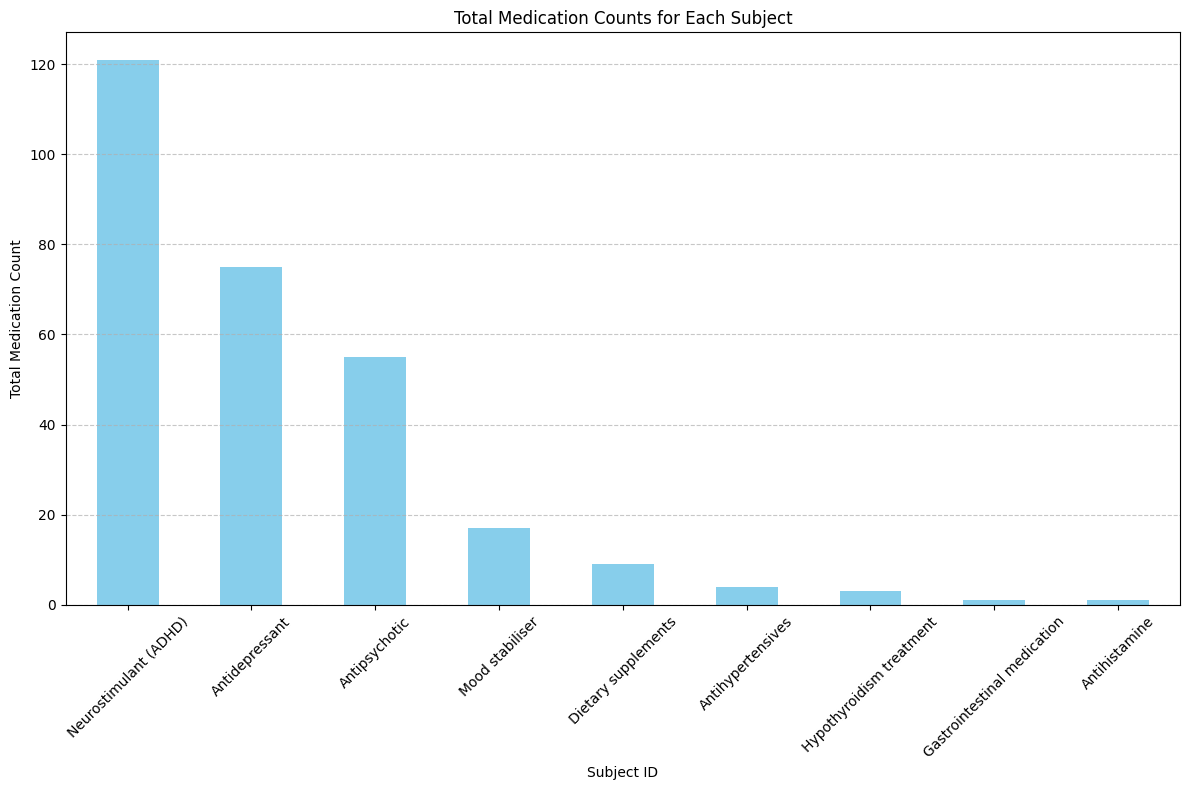

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))
medication_counts_df.sum(axis=1).sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Total Medication Counts for Each Subject')
plt.xlabel('Subject ID')
plt.ylabel('Total Medication Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
#As we can see there is a predominant presence of subjects that takes medicines to treat neurological disorders,
#while for other diseases we have less frequency. There are also subjects that takes more than one pharmac of different categories.
#To make a more efficient categorization we decide to label subjects in the following way:
# - takes more than one medicine to treat neurological disorders, as MULTIPLE_NEUROLOGICAL_TREATMENT
# - if takes a medicine to treat neurological disorders and other type of pharmac, it will be categorized by the first one
# - if takes Antihypertensives, Hypothyroidism treatment or gastrointestinal medication, as OTHER_PATHOLOGIES_TREATMENT
# - if takes only antihistamine or dietary supplements, it will be catalogated with the respective label (as these aren't pathologies)


# Function to categorize medication list
def categorize_medication(medications):
    # Initialize labels list
    labels = []
    
    # Initialize category set to keep track of categories
    categories = set()
    
    # Iterate over medications
    for medication in medications:
        # Check which category the medication belongs to
        for category, meds in treatment_categories.items():
            if medication in meds:
                categories.add(category)
                break
    
    # Check for multiple neural disorder
    neural_categories = {"Antidepressant", "Neurostimulant (ADHD)", "Antipsychotic", "Mood stabiliser"}
    if len(categories.intersection(neural_categories)) > 1:
        labels.append("MULTIPLE_NEURAL_DISORDER")
    
    # Check for other pathologies treatment
    other_pathologies_categories = {"Hypothyroidism treatment", "Antihypertensives", "Gastrointestinal medication"}
    if categories.intersection(other_pathologies_categories):
        labels.append("OTHER_PATHOLOGIES_TREATMENT")
    
    # Add individual medication categories as labels
    labels.extend(categories)
    
    return labels

# Apply categorization function to each subject's medication list
ASD_phenotypic['MEDICATION_NAME'] = ASD_phenotypic['MEDICATION_NAME'].apply(categorize_medication)

# Accesso a una specifica colonna categorica utilizzando la lista di nomi
specific_category_column = ASD_phenotypic[categorical_column_names[7]].value_counts(dropna=False)
specific_category_column

NameError: name 'treatment_categories' is not defined

# ENCODING


In order to proceed with a Correlation Matrix to exclude some features from our analysis we need to transform categorical features into numerical ones. 
Since the absence of internal order and not a huge quantity of different unique categories inside each feature, we select one-hot encoding technique

In [ ]:
# Utilizza la funzione get_dummies() di pandas per eseguire il one-hot encoding
ASD_phenotypic_encoded = pd.get_dummies(ASD_phenotypic_filtered, columns=categorical_columns_filtered)

# Ora ASD_phenotypic_encoded contiene le colonne originali numeriche insieme alle nuove colonne one-hot encoded


In [ ]:

# Visualizza l'intero contenuto del DataFrame
print(ASD_phenotypic_encoded.to_string())

In [ ]:
ASD_phenotypic_encoded.info()

# ALGORITMO AURI

We created an algorithm that sequentially drop small amounts of subjects and features to converge to a reduced size dataset that ensure a maximum of 10% of missing values per feature.

In [ ]:
# This function receives as parameters:
# - c_f that is the percentage of features that can delete per loop repetition
# - c_s that is the percentage of subjects that can delete per loop repetition
# - dataset that is the original dataset
# - max_nan_allowed that indicates the maximus percentage of nans allowed per feature

# Return a list containing:
# [0] - final number of selected features
# [1] - final number of subjects features 
# [2] - selected features with nan values
# and the shrinked dataset


def clean_dataset (c_f, c_s, main_dataset, side_dataset):
    ASD_phenotypic = main_dataset.copy()
    ASD_clinical = side_dataset.copy()
    max_nan_allowed = 0.1 #definided minimum amount of allowed missing values

    num_subjects, num_features = ASD_phenotypic.shape

    feature_nan_values = ASD_phenotypic.isna().sum()
    max_feature_nan_actual = feature_nan_values.max()
    perc_max_feature_nan = max_feature_nan_actual/num_subjects

    while perc_max_feature_nan > max_nan_allowed:

        subject_nan_values = ASD_phenotypic.T.isna().sum()
        subject_nan_values_sorted = subject_nan_values.sort_values(ascending=True)
        to_drop = round(c_s * num_subjects)
        subjects_to_drop = subject_nan_values_sorted[num_subjects-to_drop:].index
        
        ASD_phenotypic.drop(subjects_to_drop, inplace=True)
        ASD_clinical.drop(subjects_to_drop, inplace=True)

        num_subjects, num_features = ASD_phenotypic.shape
        
        feature_nan_values = ASD_phenotypic.isna().sum()
        max_feature_nan_actual = feature_nan_values.max()
        perc_max_feature_nan = max_feature_nan_actual/num_subjects

        if perc_max_feature_nan > max_nan_allowed:
            feature_nan_values_sorted = feature_nan_values.sort_values(ascending=True)
            to_drop = round(c_f * num_features)
            features_to_drop = feature_nan_values_sorted[num_features-to_drop:].index
            ASD_phenotypic.drop(columns=features_to_drop, inplace=True)
            
            num_subjects, num_features = ASD_phenotypic.shape

            feature_nan_values = ASD_phenotypic.isna().sum()
            max_feature_nan_actual = feature_nan_values.max()
            perc_max_feature_nan = max_feature_nan_actual/num_subjects

    num_subjects, num_features = ASD_phenotypic.shape
    return [[c_f, c_s], [num_features, num_subjects], feature_nan_values], ASD_phenotypic, ASD_clinical

To optimize the function in order to find the best solution we need to search for different values of the parameters c_f and c_s. In order to do that, we will perform a grid search. In this way we try 22 values for c_f and 24 values for c_s and all of the combination between them.

In order to save space, we decide to store only the results that ensure to conserve at least 1/4 of the total amount of subjects and that gives a variety of at least more than 10 features.

In [ ]:
param_grid = {
    'c_f': [0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075,
             0.08, 0.085, 0.9, 0.095, 0.1, 0.105, 0.11, 0.115, 0.2, 0.25, 0.3],
    'c_s': [0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07,
             0.075,  0.08, 0.085, 0.9, 0.095, 0.1,0.105, 0.11, 0.115, 0.2, 0.25, 0.3]
}

param_combinations = ParameterGrid(param_grid)

stored_outcomes = []

rows = ASD_phenotypic.shape[0]
for params in param_combinations:

    c_f = params.get('c_f')
    c_s = params.get('c_s')

    outcome, main_data_cleaned, side_data_cleaned = clean_dataset (c_f, c_s, ASD_phenotypic, ASD_clinical)

    if (outcome[1][1] >= 0.25 * rows) and (outcome[1][0] > 10):
        dx_group = side_data_cleaned['DX_GROUP'].value_counts()
        dx_group_balance = dx_group.tolist()

        if len(dx_group_balance)>1:
            
            stored_outcomes.append([outcome, dx_group_balance])


In [ ]:
# This function receives as parameters:
# - c_f that is the percentage of features that can delete per loop repetition
# - c_s that is the percentage of subjects that can delete per loop repetition
# - dataset that is the original dataset
# - max_nan_allowed that indicates the maximus percentage of nans allowed per feature

# Return a list containing:
# [0] - final number of selected features
# [1] - final number of subjects features 
# [2] - selected features with nan values
# and the shrinked dataset


def clean_dataset (c_f, c_s, main_dataset, side_dataset):
    ASD_phenotypic = main_dataset.copy()
    ASD_clinical = side_dataset.copy()
    max_nan_allowed = 0.1 #definided minimum amount of allowed missing values

    num_subjects, num_features = ASD_phenotypic.shape

    feature_nan_values = ASD_phenotypic.isna().sum()
    max_feature_nan_actual = feature_nan_values.max()
    perc_max_feature_nan = max_feature_nan_actual/num_subjects

    while perc_max_feature_nan > max_nan_allowed:

        subject_nan_values = ASD_phenotypic.T.isna().sum()
        subject_nan_values_sorted = subject_nan_values.sort_values(ascending=True)
        to_drop = round(c_s * num_subjects)
        subjects_to_drop = subject_nan_values_sorted[num_subjects-to_drop:].index
        
        ASD_phenotypic.drop(subjects_to_drop, inplace=True)
        ASD_clinical.drop(subjects_to_drop, inplace=True)

        num_subjects, num_features = ASD_phenotypic.shape
        
        feature_nan_values = ASD_phenotypic.isna().sum()
        max_feature_nan_actual = feature_nan_values.max()
        perc_max_feature_nan = max_feature_nan_actual/num_subjects

        if perc_max_feature_nan > max_nan_allowed:
            feature_nan_values_sorted = feature_nan_values.sort_values(ascending=True)
            to_drop = round(c_f * num_features)
            features_to_drop = feature_nan_values_sorted[num_features-to_drop:].index
            ASD_phenotypic.drop(columns=features_to_drop, inplace=True)
            
            num_subjects, num_features = ASD_phenotypic.shape

            feature_nan_values = ASD_phenotypic.isna().sum()
            max_feature_nan_actual = feature_nan_values.max()
            perc_max_feature_nan = max_feature_nan_actual/num_subjects

    num_subjects, num_features = ASD_phenotypic.shape
    return [[c_f, c_s], [num_features, num_subjects], feature_nan_values], ASD_phenotypic, ASD_clinical

In order to choose one of them, we decide to maintain the one that maintan better differenciation between the two classes of the diagnostic.

In [ ]:
#Find ten best results

best_results = [[1000,0,0,0,0], [1000,0,0,0,0], [10000,0,0,0,0], [1000,0,0,0,0], [1000,0,0,0,0], [10000,0,0,0,0], [1000,0,0,0,0], [1000,0,0,0,0], [10000,0,0,0,0], [10000,0,0,0,0]]

for i in range (len(stored_outcomes)):
    class_counts = stored_outcomes[i][1]
    balance = class_counts[0]-class_counts[1]
    differences_score = []
    for j in range (len(best_results)):
        difference = balance - best_results[j][0]
        differences_score.append(difference)
    min_value = min(differences_score)
    if min_value < 0:
        index_max = differences_score.index(min_value)
        best_results[index_max] = [balance, stored_outcomes[i][0][1][0], stored_outcomes[i][0][1][1], stored_outcomes[i][0][0],stored_outcomes[i][0][2]]

sorted_best_results = sorted(best_results, key=lambda x: x[0])
for result in sorted_best_results:

    print(result)

Then, the best result is achieved by c_f = 0.075, c_s = 0.06, that gives us 13 features and 279 subjects.

In [ ]:
outcome, ASD_phenotypic_filtered, ASD_clinical_filtered = clean_dataset (0.075, 0.06, ASD_phenotypic, ASD_clinical)
print(outcome)

In [ ]:
# Count of the missing values
nan_values = ASD_phenotypic_filtered.isna().sum()
nan_sorted = nan_values.sort_values(ascending=False)

# We implemented a function "select_columns", that is able to define wich columns are numerical
# and which ones are categorical (also redefine the objects as categorical in the dataset)
numeric_columns, categorical_columns, ASD_phenotypic_filtered = of.select_columns(ASD_phenotypic_filtered)

# We plot the distribution of missing values, with the specification of numeric and categorical columns
of.plot_missing_values(nan_sorted, numeric_columns, legend=True)
plt.show()

We want to check if our dataset still balanced

In [ ]:
# Calcola il conteggio delle classi per DX_GROUP
class_counts_DX_GROUP = ASD_clinical_filtered['DX_GROUP'].value_counts()

# Stampa il conteggio delle classi per DX_GROUP
print("Conteggio delle classi per DX_GROUP:")
print(class_counts_DX_GROUP)

# Visualizza la distribuzione delle classi per DX_GROUP
class_counts_DX_GROUP.plot(kind='bar', color='blue')
plt.title('Distribuzione delle classi per DX_GROUP')
plt.xlabel('Classe')
plt.ylabel('Numero di campioni')
plt.xticks(rotation=0)
plt.show()

# Calcola le proporzioni delle classi per DX_GROUP
class_proportions_DX_GROUP = ASD_clinical_filtered['DX_GROUP'].value_counts(normalize=True)

# Stampa le proporzioni delle classi per DX_GROUP
print("\nProporzioni delle classi per DX_GROUP:")
print(class_proportions_DX_GROUP)


Now the dataset is strongly unbalanced.

OPTIMIZATION GRID SEARCH

In [ ]:

def clean_dataset (c_f, c_s, dataset):
    ASD_phenotypic_modified = dataset.copy()
    max_nan_allowed = 0.1

    num_subjects, num_features = ASD_phenotypic_modified.shape

    feature_nan_values = ASD_phenotypic_modified.isna().sum()
    max_feature_nan_actual = feature_nan_values.max()
    perc_max_feature_nan = max_feature_nan_actual/num_subjects

    while perc_max_feature_nan > max_nan_allowed:

        subject_nan_values = ASD_phenotypic_modified.T.isna().sum()
        subject_nan_values_sorted = subject_nan_values.sort_values(ascending=True)
        to_drop = round(c_s * num_subjects)
        subjects_to_drop = subject_nan_values_sorted[num_subjects-to_drop:].index
        
        ASD_phenotypic_modified.drop(subjects_to_drop, inplace=True)
        num_subjects, num_features = ASD_phenotypic_modified.shape

        feature_nan_values = ASD_phenotypic_modified.isna().sum()
        max_feature_nan_actual = feature_nan_values.max()
        perc_max_feature_nan = max_feature_nan_actual/num_subjects
        

        if perc_max_feature_nan > max_nan_allowed:
            feature_nan_values_sorted = feature_nan_values.sort_values(ascending=True)
            to_drop = round(c_f * num_features)
            features_to_drop = feature_nan_values_sorted[num_features-to_drop:].index
            ASD_phenotypic_modified.drop(columns=features_to_drop, inplace=True)
            num_subjects, num_features = ASD_phenotypic_modified.shape

            feature_nan_values = ASD_phenotypic_modified.isna().sum()
            max_feature_nan_actual = feature_nan_values.max()
            perc_max_feature_nan = max_feature_nan_actual/num_subjects

    num_subjects, num_features = ASD_phenotypic_modified.shape
    return [[c_f, c_s], [num_features, num_subjects, (num_features*num_subjects)/((num_features**2)+num_subjects)], feature_nan_values]

In [ ]:
'''param_grid = {
    'c_f': [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05,
             0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1],
    'c_s': [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05,
             0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1]
}'''

param_grid = {
    'c_f': [0.025, 0.04, 0.045, 0.055, 0.07, 0.085, 0.1],
    'c_s': [0.025, 0.04, 0.045, 0.055, 0.07, 0.085, 0.1]
}

stored_outcomes = []

param_combinations = ParameterGrid(param_grid)
for params in param_combinations:

    print("trying with: " + str(params))
    c_f = params.get('c_f')
    c_s = params.get('c_s')

    outcome = clean_dataset (c_f, c_s, ASD_phenotypic_original)
    stored_outcomes.append(outcome)

#Find ten best results

best_results = [[0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0],
                 [0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0]]

for i in range (len(stored_outcomes)):
    this_score = stored_outcomes[i][1][2]
    differences_score = []
    for j in range (len(best_results)):
        difference = this_score - best_results[j][0]
        differences_score.append(difference)
    max_value = max(differences_score)
    if max_value > 0:
        index_max = differences_score.index(max_value)
        best_results[index_max] = [this_score, stored_outcomes[i][1][0], stored_outcomes[i][1][1], stored_outcomes[i][0],stored_outcomes[i][2]]

sorted_best_results = sorted(best_results, key=lambda x: x[0])
for result in sorted_best_results:

    print(result)



trying with: {'c_f': 0.025, 'c_s': 0.025}
trying with: {'c_f': 0.025, 'c_s': 0.04}
trying with: {'c_f': 0.025, 'c_s': 0.045}
trying with: {'c_f': 0.025, 'c_s': 0.055}
trying with: {'c_f': 0.025, 'c_s': 0.07}
trying with: {'c_f': 0.025, 'c_s': 0.085}
trying with: {'c_f': 0.025, 'c_s': 0.1}
trying with: {'c_f': 0.04, 'c_s': 0.025}
trying with: {'c_f': 0.04, 'c_s': 0.04}
trying with: {'c_f': 0.04, 'c_s': 0.045}
trying with: {'c_f': 0.04, 'c_s': 0.055}
trying with: {'c_f': 0.04, 'c_s': 0.07}
trying with: {'c_f': 0.04, 'c_s': 0.085}
trying with: {'c_f': 0.04, 'c_s': 0.1}
trying with: {'c_f': 0.045, 'c_s': 0.025}
trying with: {'c_f': 0.045, 'c_s': 0.04}
trying with: {'c_f': 0.045, 'c_s': 0.045}
trying with: {'c_f': 0.045, 'c_s': 0.055}
trying with: {'c_f': 0.045, 'c_s': 0.07}
trying with: {'c_f': 0.045, 'c_s': 0.085}
trying with: {'c_f': 0.045, 'c_s': 0.1}
trying with: {'c_f': 0.055, 'c_s': 0.025}
trying with: {'c_f': 0.055, 'c_s': 0.04}
trying with: {'c_f': 0.055, 'c_s': 0.045}
trying with:

In [ ]:
sorted_best_results = sorted(best_results, key=lambda x: x[0])
for result in sorted_best_results:

    print(result)

[9.411371237458194, 14, 402, [0.07, 0.04], SITE_ID                   0
SUB_ID                    0
DX_GROUP                  0
DSM_IV_TR                 0
AGE_AT_SCAN               0
SEX                       0
FIQ                       0
VIQ                      34
ADI_R_SOCIAL_TOTAL_A      0
ADI_R_VERBAL_TOTAL_BV     0
ADI_RRB_TOTAL_C           0
ADI_R_RSRCH_RELIABLE      3
ADOS_MODULE               0
EYE_STATUS_AT_SCAN        0
dtype: int64]
[9.43612334801762, 18, 357, [0.07, 0.055], SITE_ID                   0
SUB_ID                    0
DX_GROUP                  0
DSM_IV_TR                 0
AGE_AT_SCAN               0
SEX                       0
FIQ                       0
VIQ                       1
PIQ                       1
VIQ_TEST_TYPE            15
PIQ_TEST_TYPE            15
ADI_R_SOCIAL_TOTAL_A      1
ADI_R_VERBAL_TOTAL_BV     1
ADI_RRB_TOTAL_C           1
ADI_R_RSRCH_RELIABLE      4
ADOS_MODULE               0
ADOS_RSRCH_RELIABLE      20
EYE_STATUS_AT_SCAN        0
dtyp

## Brutal Filtering

In [ ]:
# We set the maximum quantity of missinf values that are allowed
max_missing_values = len(ASD_phenotypic) * 0.70

# Trova le colonne con un numero di valori mancanti superiore al limite consentito
columns_to_drop = []
for column, missing_count in nan_values.items():
    if missing_count > max_missing_values:
        columns_to_drop.append(column)

# Rimuovi le colonne con un numero di valori mancanti eccessivo
ASD_phenotypic_filtered = ASD_phenotypic.drop(columns=columns_to_drop)

# Stampa le colonne rimosse
print("The columns that have been removed are:")
for column in columns_to_drop:
    print(column)


In [ ]:
ASD_phenotypic_filtered

So, now we have to analyse only 23 features.

In [1]:
# Calcolo dei valori mancanti e ordinamento
nan_values_filtered = ASD_phenotypic_filtered.isna().sum()
columns_with_nan_sorted_filtered = nan_values_filtered.sort_values(ascending=False)

# Selezione delle colonne numeriche e categoriche
numeric_columns_filtered, categorical_columns_filtered, ASD_phenotypic_filtered = of.select_columns(ASD_phenotypic_filtered)

# Plot dei valori mancanti
of.plot_missing_values(columns_with_nan_sorted_filtered, numeric_columns_filtered, legend=True)

NameError: name 'ASD_phenotypic_filtered' is not defined

# vecchia parte su esplorazione categoriche e missing values

### HANDEDNESS_CATEGORY

This should be applied at the final????

We can see that we have values for R, L and Ambi, Mixed, L->R. The dataset include as a feature also a handness score where right-handed subjects has positive score (max = 100), left-handed subjects negative score (min = -100) and ambidextreus subjects has 0 score. 

To be coherent with that categorization and can properly evaluate if one of those features contain redudant information or that can be merged in some manner, we decide to assign to R values the number "100", to L values the number "-100" and to Ambi, Mixed, L->R the number "0".

HANDEDNESS_CATEGORY refers to the handedness of the subject. We don't really know if there is a correlation or not between the Autism Disease and the handnedness of the subject and as it is a caracteristic of the subject itselfs and not of the specific site of analysis as in the previous case, we decide to work with this feature.

In [ ]:
# Accesso a una specifica colonna categorica utilizzando la lista di nomi
specific_category_column = ASD_phenotypic_filtered[categorical_column_names[1]].value_counts(dropna=False)
specific_category_column

We can see that there are incongruences for the Ambidextreus group, so we will replace them (Mixed and L->R) for Ambi.

In [ ]:
# Define a custom function to replace categories and NaN values
def replace_categories_and_nan(category):
    if category in ['MIXED', 'L->R']:
        return 'AMBI'
    else:
        return category

# Apply the custom function to the categorical column
ASD_phenotypic_filtered[categorical_column_names[1]] = ASD_phenotypic_filtered[categorical_column_names[1]].apply(replace_categories_and_nan).astype('category')

# Display the new result
specific_category_column = ASD_phenotypic_filtered[categorical_column_names[1]].value_counts(dropna=False)
specific_category_column

To understand better how to treat the information gived by this categorical variables we are interested in know which values are stored in this features. We will analyze all of them.


Thanks to the implemented tolist, we can acced to specific elements.
We prefer create viasual subsections in order to manage these features, but we could implement a 'for logic' in order to guarantee a correct automatic work also in case of modifications on dataset.

For each categorical feature, we want to investigate the amount of informations given. We suppose that for our specific scope we could drop some uninformative features, but we want to proof it. In which way? 
- Evaluating the amount of info considering Nan as Nan
- Changing Missing values with specific feature engineering rules
- Evaluating the amount of info with Nan evalueted

We use Entropy logic.
If both have high level of entropy we can drop the feature.

# current med status

This feature indicates if the subject is taking any medication or not. If the subject doesn't take any medication is labeled with a "0" in the other case with a "1".

In [ ]:
# Accesso a una specifica colonna categorica utilizzando la lista di nomi
specific_category_column = ASD_phenotypic_filtered[categorical_column_names[5]].value_counts(dropna=False)
specific_category_column

We can see that the only attribute that is not numeric is the "`", we will catalogate it as a NaN.

In [ ]:
# Define a custom function to replace categories and NaN values
def replace_categories_and_nan(category):
    if category in ["`"]:
        return np.nan
    else:
        return category

# Apply the custom function to the categorical column
ASD_phenotypic_filtered[categorical_column_names[5]] = ASD_phenotypic_filtered[categorical_column_names[5]].apply(replace_categories_and_nan).astype('float64')

# Display the new result
specific_category_column = ASD_phenotypic_filtered[categorical_column_names[5]].value_counts(dropna=False)
specific_category_column

# current med status

We decide to proceed with the same logic used for IQ_TEST_TYPE. We make a comparison with another linked feature: CURRENT_MED_STATUS. If there is a value, so we fill missing value with 1, if there is anything we insert the mode.

In [ ]:
for index, row in ASD_phenotypic_filtered.iterrows():
    # Ottieni l'indice della riga corrente nel DataFrame originale
    original_index = row.name
    
    # Accedi ai valori corrispondenti di MEDICATION_NAME nel DataFrame originale
    medication_name_value = ASD_phenotypic_original.at[original_index, 'MEDICATION_NAME']
    
    if pd.isnull(medication_name_value) and pd.isnull(row['CURRENT_MED_STATUS']):
        # Se entrambi i valori in 'MEDICATION_NAME' e 'CURRENT_MED_STATUS' sono mancanti
        # Riempire 'CURRENT_MED_STATUS' con la moda di 'CURRENT_MED_STATUS'
        mode_current_med_status = ASD_phenotypic_filtered['CURRENT_MED_STATUS'].mode()[0]
        ASD_phenotypic_filtered.at[index, 'CURRENT_MED_STATUS'] = mode_current_med_status
    elif pd.notnull(medication_name_value) and pd.isnull(row['CURRENT_MED_STATUS']):
        # Se il valore in 'MEDICATION_NAME' è presente e il valore in 'CURRENT_MED_STATUS' è mancante
        # Imposta 'CURRENT_MED_STATUS' su 1
        ASD_phenotypic_filtered.at[index, 'CURRENT_MED_STATUS'] = 1
